## Genius Song Lyrics: Topic Modeling and Text Classification
### Text Mining Project
#### Mattia Simone 901716 & Montalbano Daniel 897383

Music has always held a profound place in human culture, serving as a powerful medium of expression, emotion, and connection. The lyrics of songs, in particular, provide a unique lens into the human experience, reflecting the myriad of emotions, stories, and perspectives that shape our lives. In the digital age, the availability of vast amounts of music and lyrics data has opened up new possibilities for exploration and analysis.

This project delves into the world of song lyrics, exploiting the potential of text mining techniques to extract meaningful information from the Kaggle Genius Song Lyrics dataset.
By integrating topic modelling and text classification methods, the primary goal is to build a predictive model capable of determining genre, identifying relevant topics, and suggesting similar songs based solely on the textual content of a given song.

#### Define settings for Data Loading

You can change certain project parameters by modifying the constants defined in the next cell of whis notebook.

In [1]:
# Dataset loading
LANG = "italian"
LANG_CODE = "it"
DECADES = [1950, 1960, 1970, 1980, 1990, 2000, 2010, 2020]
RELOAD_DATASET = False
FORCE_PREPROCESSING = False
TEST_SIZE = 0.2

# Topig modeling
FORCE_TOPIC_MODELING = False
NUM_TOPICS = 30
PASSES = 15
SHOW_GUI = False

# Classification
FORCE_CLASSIFICATION = False
MAX_FEATURES = 100000

#### Import Libraries
Run it once to import all the libraries, in order to execute the project.

In [2]:
import gensim
import json
import nltk
import numpy as np
import os
import pandas as pd
import pickle
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import re
import scipy
import sklearn
import sklearn.decomposition
import sklearn.ensemble
import sklearn.feature_selection
import sklearn.naive_bayes
import string
import tensorflow as tf
import matplotlib.pyplot as plt

2024-01-23 10:26:21.068774: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-23 10:26:21.131360: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-23 10:26:21.610202: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-23 10:26:21.612046: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-23 10:26:23.473698: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

#### Loading Data

If it is not forced, the notepad uses the already filtered dataset for the language set if it is available, otherwise the original dataset is loaded to filter it.
Due to the large size of the Kaggle dataset, it is loaded by dividing it into pieces of size 1000000 and filtered according to the required language and decades.
Then we divided the data into training and test subsets.

Note: when the dataset is reloaded, the settings are changed to force all analyses as the data has changed.

In [3]:
def load_dataset():
    dataset = {decade:pd.DataFrame() for decade in DECADES}
    if RELOAD_DATASET or not os.path.exists(f"data/song_lyrics_{LANG_CODE}.csv"):
        df_chunk = pd.read_csv("data/song_lyrics.csv",
                        chunksize=1000000,
                        usecols=[
                            'title',
                            'tag',
                            'artist',
                            'views',
                            'features',
                            'lyrics',
                            'language',
                            'year'])
        for chunk in df_chunk:   
            for decade in DECADES:
                chunk_filter = chunk[(chunk["language"]==LANG_CODE) & (chunk["year"]>=decade) & (chunk["year"]<decade+10)] 
                dataset[decade] = pd.concat([dataset[decade], chunk_filter])  
        for decade in DECADES:
            dataset[decade]["decade"] = decade 
        dataset = pd.concat([dataset[decade] for decade in DECADES])
        dataset.to_csv(f"data/song_lyrics_{LANG_CODE}.csv", index=False)
    else:
        dataset = pd.read_csv(f"data/song_lyrics_{LANG_CODE}.csv")
        if "lyrics_processed" in dataset.columns:
            dataset["lyrics_processed"] = dataset["lyrics_processed"].apply(lambda x: x[1:-1].replace("'", "").split(", ")) 
    return dataset

def train_test_split(dataset, test_size=0.2):
    dataset_train, dataset_test = sklearn.model_selection.train_test_split(dataset, test_size=test_size)
    print(f"Dataset {LANG_CODE}: {dataset.shape}")
    print(f"- train: {dataset_train.shape}")
    print(f"- test:  {dataset_test.shape}")
    return dataset_train, dataset_test

# Force topic modeling and classification training if the dataset has been reloaded
if RELOAD_DATASET or not os.path.exists(f"data/song_lyrics_{LANG_CODE}.csv"):
    FORCE_TOPIC_MODELING = True
    FORCE_CLASSIFICATION = True

# Load dataset and split to train and test
dataset = load_dataset()

#### Data Preprocessing

Loading the Stopwords:

In [4]:
def loadStopoWords():
    stopword_setting = json.load(open("data/stopwords.json"))
    nltk.download('stopwords')
    stopwords = nltk.corpus.stopwords.words("english")
    if LANG != "english":
        stopwords += nltk.corpus.stopwords.words(LANG)
    # Remove Stopwords
    for x in stopword_setting["exclude"]: 
        if x in stopwords:
            stopwords.remove(x)
    # Add Stopwords
    for x in stopword_setting["include"]: 
        if x not in stopwords:
            stopwords.append(x)
    return stopwords

STOPWORDS = loadStopoWords()

[nltk_data] Downloading package stopwords to /home/simon/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


This function get a text as input and performs several tasks to preprocess text, including removing punctuation, removing numbers, removing stopwords.
It performs also tokenization using nklt library and tokenization. 

In [5]:
def preprocess_text(text):
    
    # Convert text to lowercase
    text = text.lower()
    
    # Remove text in square brackets (e.g. [intro])
    text = re.sub(r'\[.*?\]', '', text)

    # Remove punctuation
    text = text.translate(str.maketrans("", "", string.punctuation))
    
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text)
    
    # Remove leading/trailing whitespace
    text = text.strip()

    # Limiting all the repeatation to two characters
    pattern = re.compile(r"([A-Za-z])\1{2,}", re.DOTALL)
    text = pattern.sub(r"\1\1", text) 
    
    # Remove stopwords
    text = " ".join([word for word in text.split() if word not in STOPWORDS])

    # Tokenization
    tokens = nltk.word_tokenize(text)

    # Lemmatization
    tokens = [nltk.stem.wordnet.WordNetLemmatizer().lemmatize(token) for token in tokens]

    # Remove tokens with less than 4 characters
    tokens = [t for t in tokens if len(t)>3]

    return tokens

More preprocessing:

In [6]:

if FORCE_PREPROCESSING or "lyrics_processed" not in dataset.columns:
    
    # Required for lemmatization
    nltk.download('punkt')
    nltk.download('wordnet')
    nltk.download("omw-1.4")

    # Preprocess lyrics
    dataset["lyrics_processed"] = dataset["lyrics"].apply(preprocess_text)

    # Fix tags columns
    dataset["tag"] = dataset["tag"].fillna("")
    dataset["tag"] = dataset["tag"].apply(lambda x: x.replace(" ", "_"))

    # Save dataset
    dataset.to_csv(f"data/song_lyrics_{LANG_CODE}.csv", index=False)

dataset_train, dataset_test = train_test_split(dataset, test_size=TEST_SIZE)

[nltk_data] Downloading package punkt to /home/simon/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/simon/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/simon/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Dataset it: (118387, 10)
- train: (94709, 10)
- test:  (23678, 10)


#### Exploratory Analysis

The columns of our dataset after pre-processing:

In [7]:
dataset.head()

,title,tag,artist,year,views,features,lyrics,language,decade,lyrics_processed
462285,Sedici Anni,pop,Achille Togliani,1951,71,{},Se gli anni rinverdissero\nCome le foglie in p...,it,1950,"[anni, rinverdissero, foglie, primavera, allor..."
583414,O Suspiro,pop,Renato Carosone,1959,182,{},Si mammeta t'ha fatto c' abbundanza\nSti sutta...,it,1950,"[mammeta, fatto, abbundanza, suttanelle, stret..."
593078,Tintarella di luna,pop,Mina,1959,4394,{},"[Introduzione]\nAbbronzate, tutte chiazze\nPel...",it,1950,"[abbronzate, tutte, chiazze, pelli, rosse, pao..."
616705,Non Arrossire,pop,Giorgio Gaber,1959,333,{},[Ritornello]\nNon arrossire\nQuando ti guardo\...,it,1950,"[arrossire, quando, guardo, ferma, cuore, trem..."
648835,Il Tuo Bacio È Come Un Rock,pop,Adriano Celentano,1959,353,{},Il tuo bacio è come un rock\nChe ti morde col ...,it,1950,"[bacio, rock, morde, swing, assai, facile, kno..."


In [8]:
dataset.describe()

,year,views,decade
count,118387.000000,1.183870e+05,118387.000000
mean,2009.801051,2.116283e+03,2005.402536
std,14.248228,1.465638e+04,14.771671
min,1951.000000,0.000000e+00,1950.000000
25%,2006.000000,2.100000e+01,2000.000000
50%,2016.000000,6.800000e+01,2010.000000
75%,2019.000000,3.410000e+02,2010.000000
max,2023.000000,1.919531e+06,2020.000000


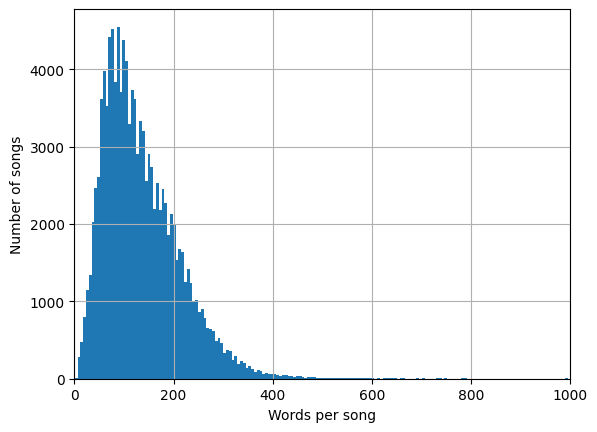

count    118387.000000
mean        136.414015
std          82.601549
min           1.000000
25%          78.000000
50%         120.000000
75%         180.000000
max        5645.000000
Name: words_per_song, dtype: float64


In [9]:
def plot_words_per_song(dataset):
    dataset["words_per_song"] = dataset["lyrics_processed"].apply(lambda x: len(x))
    dataset["words_per_song"].hist(bins=1000)
    plt.xlim(0, 1000)
    plt.xlabel("Words per song")
    plt.ylabel("Number of songs")
    plt.show()
    print(dataset["words_per_song"].describe())

plot_words_per_song(dataset)

As we can see, the songs as in media 120 words length

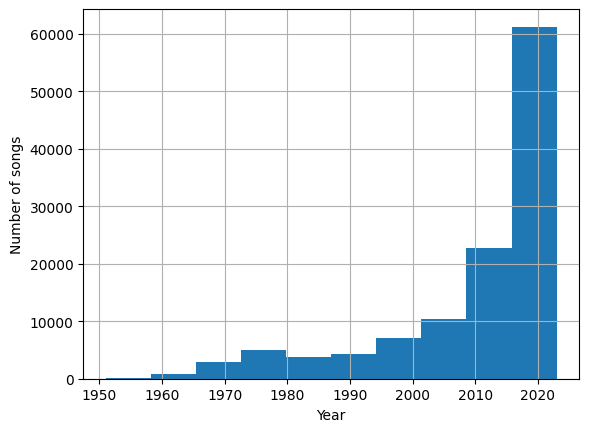

year
2020    13670
2021    12323
2019    11693
2018     9297
2015     8114
        ...  
1951        5
1952        3
1953        3
2023        3
1954        1
Name: count, Length: 73, dtype: int64


In [10]:
#plot distribution of songs per year
def plot_songs_per_decade(dataset):
    dataset["year"].hist()
    plt.xlabel("Year")
    plt.ylabel("Number of songs")
    plt.show()
    print(dataset["year"].value_counts())

plot_songs_per_decade(dataset)

Otherwise the songs are in a range between 1954 and 2020, the songs are major distributed in the last decades, so this factor could influence the topic distribution or the terms used in the songs.

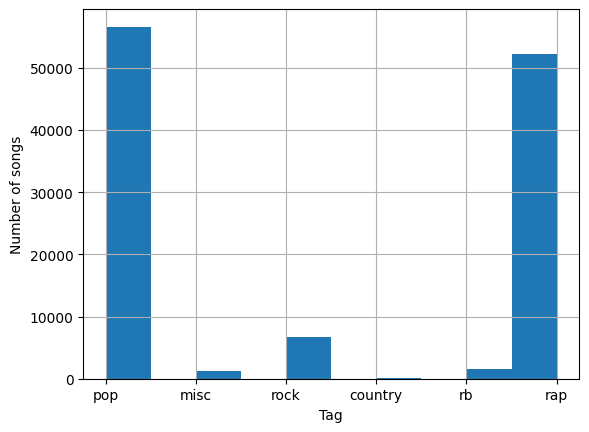

In [11]:
#plot distribution of songs per tag
def plot_songs_per_tag(dataset):
    dataset["tag"].hist()
    plt.xlabel("Tag")
    plt.ylabel("Number of songs")
    plt.show()
    #print(dataset["tag"].value_counts())

plot_songs_per_tag(dataset)

This is the graph about the tag used in the songs, as we can see the mostly tag used are rap and hip-hop. So we can say that for our classification task, a new song will be probably classified as pop or rap because of this class imbalance respect to rock, country and rb. Note that misc is for songs that not represent very well a tag.

#### Topic Modeling

Topic modeling is a powerful technique in natural language processing that allows us to extract meaningful themes or topics from a collection of textual data. In this report, we delve into the implementation and utilization of topic modeling using Latent Dirichlet Allocation (LDA) on a dataset of processed lyrics.

In our code we generate of a Gensim dictionary and corpus based on the preprocessed lyrics from the training dataset. Then, a Term Frequency-Inverse Document Frequency (TF-IDF) model is applied to the corpus to define the importance of words. An LDA model is then trained on the TF-IDF weighted corpus, and the resulting model, along with associated files, is saved for future use.

Finally we iterated through the topics generated by the trained LDA model and prints the top 5 words associated with each topic. The result is a summary of the most representative words for each identified topic.

Additionally, if the SHOW_GUI flag is set to True, an interactive graphical user interface (GUI) using pyLDAvis is displayed. This visualization tool enhances the understanding of topic distribution and relationships, offering a dynamic representation of the identified topics.

In [16]:
dictionary, corpus, lda = None, None, None

if FORCE_TOPIC_MODELING or not os.path.exists(f"models/model5.gensim"):    
    dictionary = gensim.corpora.Dictionary(dataset_train["lyrics_processed"].tolist())
    corpus = [dictionary.doc2bow(text) for text in dataset_train["lyrics_processed"].tolist()]
    
    tfidf = gensim.models.TfidfModel(corpus)
    corpus_tfidf = tfidf[corpus]

    lda = gensim.models.ldamodel.LdaModel(corpus, num_topics=NUM_TOPICS, id2word=dictionary, passes=PASSES)
    lda.save("models/model5.gensim")

    pickle.dump(corpus_tfidf, open(f"models/corpus.pkl", "wb"))
    dictionary.save(f"models/dictionary.gensim")
else:
    dictionary = gensim.corpora.Dictionary.load('models/dictionary.gensim')
    corpus = pickle.load(open('models/corpus.pkl', 'rb'))
    lda = gensim.models.ldamodel.LdaModel.load('models/model5.gensim')

for topic in lda.print_topics(num_words=5, num_topics=NUM_TOPICS):
    print(topic)

TypeError: __randomstate_ctor() takes from 0 to 1 positional arguments but 2 were given

In [ ]:
pyLDAvis.enable_notebook()
lda_display = gensimvis.prepare(lda, corpus, dictionary, sort_topics=False)
pyLDAvis.display(lda_display)

#### Topic Modeling Evaluation

The evaluation metrics employed aim to provide valuable insights into the coherence, perplexity, and diversity of the discovered topics.

- Coherence: The coherence of the LDA model is measured using the c_v coherence score. This metric evaluates the interpretability and meaningfulness of the topics by assessing the semantic similarity between high-scoring words within each topic. A higher coherence score indicates more coherent and distinct topics.
- Perplexity: it is a measure of how well the model predicts the test dataset. A lower perplexity score indicates a better-performing model. In this case, the perplexity of the LDA model is calculated based on the test dataset.
- Diversity: Topic diversity is assessed by calculating the cosine similarity matrix between the document-topic distributions of the test dataset. The average pairwise cosine similarity is then used to quantify the diversity of topics across different songs. A higher diversity score suggests a broader range of topics present in the dataset.

In [ ]:
print("Coherence:", gensim.models.CoherenceModel(model=lda, texts=dataset_test["lyrics_processed"].tolist(), dictionary=dictionary, coherence='c_v').get_coherence())
print("Perplexity:", lda.log_perplexity([dictionary.doc2bow(text) for text in dataset_test["lyrics_processed"].tolist()]))
doc_topic_matrix = lda.get_document_topics([dictionary.doc2bow(text) for text in dataset_test["lyrics_processed"].tolist()], minimum_probability=0.0)
doc_topic_array = np.array([np.array(doc_topic)[:, 1] for doc_topic in doc_topic_matrix])
cosine_sim_matrix = sklearn.metrics.pairwise.cosine_similarity(doc_topic_array)
for x in range(cosine_sim_matrix.shape[0]):
    cosine_sim_matrix[x, x] = 0 # Not consider the cosine similarity of a song with itself
topic_diversity = 1 - np.mean(np.max(cosine_sim_matrix, axis=1))
print("Diversity:", topic_diversity)

Coherence: 0.4049988719668107
Perplexity: -12.066463151502383
Diversity: 0.03246297762871997


- Coherence: The c_v coherence score of 0,405 suggests a moderate level of interpretability and meaningfulness in the topics generated by the LDA model. A higher coherence score generally indicates more coherent and distinct topics.
- Perplexity: The perplexity score of -12,066 indicates how well the LDA model predicts the test dataset. A lower perplexity score is desirable, and this value suggests a relatively good predictive performance of the LDA model on the test dataset.
- Diversity: The diversity score of 0,032 signifies a low to moderate level of diversity among topics across different songs in the dataset. This metric measures the dissimilarity of topics, and a higher diversity score would indicate a broader range of topics present in the dataset.

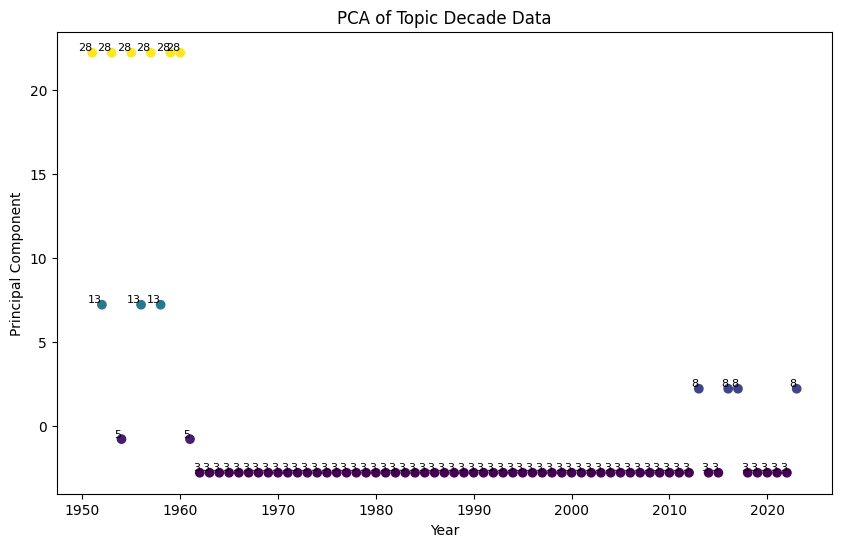

In [ ]:
#assign a topic to each year
def assign_topic(dataset):
    dataset["topic"] = dataset["lyrics_processed"].apply(lambda x: np.argmax([y[1] for y in lda.get_document_topics(dictionary.doc2bow(x))]))
    return dataset

dataset_topic = assign_topic(dataset)

#group by decade and assign the most frequent topic to each decade
def assign_topic_decade(dataset):
    dataset = dataset.groupby("year")["topic"].agg(lambda x: x.value_counts().index[0])
    return dataset

dataset_topic_decade = assign_topic_decade(dataset_topic)
dataset_topic_decade.head()

X = dataset_topic_decade.values.reshape(-1, 1)

# Perform PCA
pca = sklearn.decomposition.PCA(n_components=1)
principal_components = pca.fit_transform(X)

# Create a DataFrame with the principal components and the original years
result_df = pd.DataFrame(principal_components, columns=['Principal Component'], index=dataset_topic_decade.index)

# Plot the results
plt.figure(figsize=(10, 6))
plt.scatter(result_df.index, result_df['Principal Component'], c=result_df['Principal Component'], cmap='viridis')
plt.title('PCA of Topic Decade Data')
plt.xlabel('Year')
plt.ylabel('Principal Component')
for year, component, topic in zip(result_df.index, result_df['Principal Component'], dataset_topic_decade.values):
    plt.text(year, component, f'{topic}', fontsize=8, ha='right', va='bottom')
plt.show()

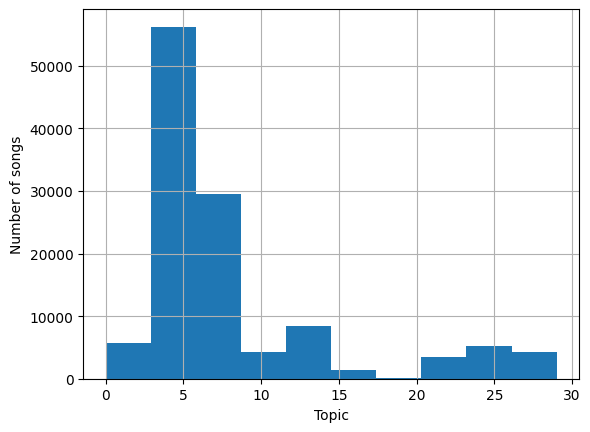

topic
3     45264
8     29276
5     10879
13     6799
1      4237
26     4121
9      3882
21     3125
28     2631
29     1474
0      1358
14     1312
16     1194
25     1001
12      315
10      232
23      158
2       145
11      129
27      125
22      123
4       101
7        84
17       83
6        76
19       67
18       55
15       52
24       49
20       40
Name: count, dtype: int64


In [ ]:
def plot_topic_per_year(dataset):
    dataset["topic"].hist()
    plt.xlabel("Topic")
    plt.ylabel("Number of songs")
    plt.show()
    print(dataset["topic"].value_counts())

plot_topic_per_year(dataset_topic)

#### Text Classification

Text classification a task where the goal is to categorize or label text documents into predefined classes or categories: in this case, the task is to classify song lyrics into music genres.

Earlier attempts involved employing multiple machine learning models with TF-IDF vectors as features. We experimented with various models and feature selection techniques, yet the achieved accuracy remained unsatisfactory.

In [ ]:
vectorizer = sklearn.feature_extraction.text.TfidfVectorizer(stop_words=STOPWORDS, max_features=MAX_FEATURES)
X_train = vectorizer.fit_transform([' '.join(x) for x in dataset_train["lyrics_processed"].tolist()])
X_test = vectorizer.transform([' '.join(x) for x in dataset_test["lyrics_processed"].tolist()])

y_train = dataset_train["tag"].tolist()
y_test = dataset_test["tag"].tolist()


"""
# Feature selection with chi2 => approx. 0.70% accuracy
sel_feature =  sklearn.feature_selection.SelectKBest(sklearn.feature_selection.chi2, k=NUM_TOPICS)
sel_feature = sel_feature.fit(X_train, y_train)
indexes = [index[0] for index, value in np.ndenumerate(sel_feature.get_support()) if value == True]
X_train = X_train[:, indexes]
X_test = X_test[:, indexes]
"""

"""
# Feature selection with SVD => approx. 0.75% accuracy
svd = sklearn.decomposition.TruncatedSVD(n_components=300)
X_train = svd.fit_transform(X_train)
X_test = svd.transform(X_test)
svd = sklearn.decomposition.TruncatedSVD(n_components=300)
X_train = svd.fit_transform(X_train)
X_test = svd.transform(X_test)
"""
FORCE_CLASSIFICATION = False

classifier = None
if FORCE_CLASSIFICATION or not os.path.exists(f"models/classifier.pkl"):
    accuracy = {}
    models = {
        "Logistic Regression": sklearn.linear_model.LogisticRegression(max_iter=200, n_jobs=-1),
        "Random Forest": sklearn.ensemble.RandomForestClassifier(n_jobs=-1), 
        "KNN": sklearn.neighbors.KNeighborsClassifier(n_jobs=-1)
    }
    print("Classification model selection:")
    for model_name in models.keys():
        models[model_name].fit(X_train, y_train)
        y_pred = models[model_name].predict(X_test)
        accuracy[model_name] = sklearn.metrics.accuracy_score(y_test, y_pred)
        print(f"- {model_name} accuracy: {round(accuracy[model_name], 2)}%")
    best_model = max(accuracy, key=accuracy.get)
    print(f"\nBest model: {best_model}")
    classifier = models[best_model]
    pickle.dump(models[best_model], open(f"models/classifier.pkl", "wb"))
else:
    print("Loading TF-IDF-based classifier...")
    classifier = pickle.load(open(f"models/classifier.pkl", "rb"))

y_pred = classifier.predict(X_test)
print(f"\nClassification TF-IDF-based accuracy: {100*round(sklearn.metrics.accuracy_score(y_test, y_pred), 4)}% accuracy")

Classification model selection:


/Users/daniel_montalbano/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


- Logistic Regression accuracy: 0.82%
- Random Forest accuracy: 0.82%
- KNN accuracy: 0.65%

Best model: Logistic Regression

Classification TF-IDF-based accuracy: 82.46% accuracy


Then, we have trained a neural network architecture using Keras, composed by the following layers: Vectorization, Embeddings, Dropout, Average Pooling, Dropout, and Dense.

In [ ]:
classes = ['rb', 'pop', 'rap', 'country', 'rock', 'misc']
y_train = tf.one_hot([classes.index(x) for x in dataset_train["tag"].tolist()], len(classes))
y_test = tf.one_hot([classes.index(x) for x in dataset_test["tag"].tolist()], len(classes))

X_train = tf.convert_to_tensor(dataset_train["lyrics_processed"].apply(lambda x: ' '.join(x)))
X_test = tf.convert_to_tensor(dataset_test["lyrics_processed"].apply(lambda x: ' '.join(x)))

tf_train = tf.data.Dataset.from_tensor_slices((X_train, y_train))
tf_test = tf.data.Dataset.from_tensor_slices((X_test, y_test))

classifier = None

if FORCE_CLASSIFICATION or not os.path.exists(f"models/classifier/"):

    vectorize_layer = tf.keras.layers.TextVectorization(max_tokens=MAX_FEATURES, output_mode='int') 
    classifier = tf.keras.Sequential([
        vectorize_layer,
        tf.keras.layers.Embedding(MAX_FEATURES, 1000),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.GlobalAveragePooling1D(),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(len(classes), activation="softmax")
    ])

    print("Training vectorizer...")
    vectorize_layer.adapt(tf_train.map(lambda x, y: x)) 
    
    print("Training classifier...")
    classifier.compile(loss=tf.losses.CategoricalCrossentropy(),
                optimizer='adam',
                metrics=["accuracy"])
    
    history = classifier.fit(
        tf_train.batch(32).prefetch(tf.data.AUTOTUNE),
        validation_data=tf_test.batch(32).prefetch(tf.data.AUTOTUNE),
        epochs=10,
        callbacks=[
            tf.keras.callbacks.ReduceLROnPlateau(monitor="val_accuracy", factor=0.1, patience=1, min_lr=1e-8, verbose=1),
            tf.keras.callbacks.ModelCheckpoint("models/classifier", monitor="val_accuracy", verbose=1, save_best_only=True),
            tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=2)])

else:
    print("Loading classifier...") 
    classifier = tf.keras.models.load_model('models/classifier')

y_pred = tf.one_hot([np.argmax(x) for x in classifier.predict(X_test)], len(classes))
print(f"\nClassification accuracy: {round(100*sklearn.metrics.accuracy_score(y_test, y_pred),2)}%")

Loading classifier...


740/740 [==============================] - 2s 2ms/step

Classification accuracy: 85.71%


#### Prediction
Finally we design a function to use all the trained models to determining genre, identifying relevant topics, and suggesting similar songs based solely on the textual content of a given song.

In [ ]:
# Prediction function
def predict(lyrics, artist, name):
    bow = dictionary.doc2bow(lyrics)
    raw_topic = lda.get_document_topics(bow, minimum_probability=0)
    topic = raw_topic[np.argmax([x[1] for x in raw_topic])][0]
    predicted_tag = classes[np.argmax(classifier.predict([' '.join(lyrics)], verbose=0)[0])]
    try:
        print(f"Song: {artist} - {name}")
        print(f"Predicted Tag: {predicted_tag}")
        print(f"Most Relevant Topic: {topic} => {topics_output[topic]}")
        valid_indexes = search_dataset[search_dataset["tag"] == predicted_tag].index.tolist()
        similar_songs = np.argsort([scipy.spatial.distance.euclidean([y[1] for y in raw_topic], train_topics[i]) if i in valid_indexes else 1 for i in range(len(train_topics))])[:5]
        print("Similar Songs:",", ".join([f"{search_dataset.iloc[x]['artist']} - {search_dataset.iloc[x]['title']}" for x in similar_songs]))
        print("--------------------")
    except:
        print(f"[!] Error")
    
# Prerequisites
topics_output = {x[0]:x[1] for x in lda.print_topics(num_words=5, num_topics=NUM_TOPICS)}
train_topics = [[y[1] for y in lda.get_document_topics(x, minimum_probability=0)] for x in corpus]
search_dataset = dataset_train.reset_index()

Some random predictions from the test set:

In [ ]:
for _,row in dataset_test.sample(5).iterrows():
    predict(row[9], row[2], row[0])

/var/folders/64/5q7586dd06zdl8fh8y6gggw80000gn/T/ipykernel_62617/1215147230.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predict(row[9], row[2], row[0])


Song: Tomm - BDG
Predicted Tag: rap
Most Relevant Topic: 3 => 0.028*"solo" + 0.015*"quando" + 0.014*"sempre" + 0.012*"volta" + 0.012*"ancora"
Similar Songs: Black Roe - Giovani Di Strada, Meddaman - Mi Sono Perso, Zioc - Roma, STRONG - Strada, Kinder Garden - Iceberg
--------------------
Song: ELASI - VALANGHE
Predicted Tag: pop
Most Relevant Topic: 3 => 0.028*"solo" + 0.015*"quando" + 0.014*"sempre" + 0.012*"volta" + 0.012*"ancora"
Similar Songs: Big Fish - Dove Stiamo Andando, Raf - Il prestigiatore, I Sentinelle - Petali e chimere, Drupi - Ho Sbagliato Secolo, Raf - Interminatamente
--------------------
Song: Shama24k - Si Vedrà
Predicted Tag: rap
Most Relevant Topic: 3 => 0.028*"solo" + 0.015*"quando" + 0.014*"sempre" + 0.012*"volta" + 0.012*"ancora"
Similar Songs: Emis Killa - Nei guai, Not Good - Come ti pare, Giaime - PAROLA, Nerissima Serpe & Papa V - XXL, Kevin Kalvin - Gemelli
--------------------
Song: SlumpthinIdle - SLUMPTHINIGLOCK
Predicted Tag: rap
Most Relevant Topic: 8

In [ ]:
def predict_user_input():
    artist = input("Artist: ")
    name = input("Song name: ")
    lyrics = input("Lyrics: ")
    lyrics = preprocess_text(lyrics)
    predict(lyrics, artist, name)
    
predict_user_input()

Song: Club dogo - Indelebili
Predicted Tag: rap
Most Relevant Topic: 1 => 0.014*"dentro" + 0.013*"sangue" + 0.009*"fuoco" + 0.009*"nero" + 0.007*"morte"
Similar Songs: Colybree - Run Up, Linea 77 - Sangue nero, Machete - Luomo contro lombra, DubZenStep - Rogo, En?gma - L’Uomo vs lOmbra
--------------------
